## An analysis of detailed COVID-19 case data published by Public Health Agency of Canada

The code in this notebook was used fo this CBC News report:

[We looked at every confirmed COVID-19 case in Canada. Here's what we found](https://www.cbc.ca/news/canada/public-health-agency-of-canada-covid-19-statistics-1.5733069)

The analysis was done in Python 3.8 using the folowing libraries:

- pandas
- matplotlib
- plotly
- seaborn
- requests

Plotly charts may not display in GitHub. You may need to donwload this notebook and install the [plotly widget for Jupyter](https://plotly.com/python/getting-started/).

### Load and prepare the data

Load the libraries

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

Download the lastest data from Statistics Canada. This also unzips the files.

In [78]:
import zipfile, requests, io

data_url = 'https://www150.statcan.gc.ca/n1/en/pub/13-26-0003/2020001/COVID19-eng.zip'

r = requests.get(data_url, stream=True)
print('Downloading table')
z = zipfile.ZipFile(io.BytesIO(r.content))
print('Extracting data')
z.extractall()

Extracting data


Load the unzipped CSV into a pandas data frame.

In [4]:
epi = pd.read_csv('COVID19-eng.csv', na_values = [99], dtype = str) 
epi.head()

Case identifier number Region Episode week Episode week group Episode year  \
0                      1      3            2                  0           21   
1                      2      2            3                  0           21   
2                      3      2            3                  0           21   
3                      4      3           35                  0           20   
4                      5      2           46                  0           20   

  Gender Age group Occupation Asymptomatic Onset week of symptoms  \
0      1         2          9            9                    NaN   
1      2         2          1            2                      3   
2      1         1          4            1                    NaN   
3      1         3          4            2                     35   
4      2         8          4            2                     46   

  Onset year of symptoms Hospital status Recovered Recovery week  \
0                    NaN               9         1           NaN   
1                     21               3         1             3   
2                    NaN               3         1             4   
3                     20               9         1           NaN   
4                     20               3         1            48   

  Recovery year Death Transmission  
0           NaN     2            9  
1            21     2            1  
2            21     2            1  
3           NaN     2            1  
4            20     2            1

A lot of the fields are encoded with ordinal values. This cell maps these numbers to their corresponding values for easier analysis.

In [5]:
gender_map = {'1' : 'Male', '2' : 'Female', '9' : 'Other/Not stated'}

region_map = {'1' : 'Atlantic', '2' : 'Quebec', '3' : 'Ontario and Nunavut', 
              '4' : 'Prairies and NWT', '5' : 'BC and YK'}

age_map = {'1' : '0 to 19', '2' : '20 to 29', '3' : '30 to 39',
               '4' : '40 to 49', '5' : '50 to 59', '6' : '60 to 69',
               '7' : '70 to 79', '8' : '80 years or older', '99' : 'Not stated'}

occupation_map = {'1' : 'Health care worker', '2' : 'School or daycare worker/attendee', 
                  '3' : 'Long term care resident', '4': 'Other', '9' : 'Not stated'}

hosp_map = {'1' : 'Hospitalized and in ICU', '2' : 'Hospitalized, not in ICU', 
            '3' : 'Not hospitalized', '9' : 'Not Stated/Unknown'}

transmission_map = {'1' : 'Domestic acquisition', '2' : 'International travel' , '9' : 'Not stated'}

other_map = {'1' : 'Yes', '2' : 'No', '9' : 'Not Stated', np.nan : np.nan}

Apply the column mappings and create a new column with the week date from the week number.

In [6]:
epi['Week of'] = pd.to_datetime('20' + epi['Episode year'] + '-' + epi['Episode week']+'-0', format = '%Y-%U-%w')

epi.Region = epi.Region.map(region_map)
epi.Gender = epi.Gender.map(gender_map)

# Create bigger age group between 80+ and younger
epi['Agg age group'] = '70-79' 
epi.loc[epi['Age group'] <= '6', 'Agg age group'] =  '0-69'
epi.loc[epi['Age group'] == '8', 'Agg age group'] = '80+'

epi['Age group'] = epi['Age group'].map(age_map)
epi.Occupation = epi.Occupation.map(occupation_map)
epi['Hospital status'] = epi['Hospital status'].map(hosp_map)
epi['Transmission'] = epi['Transmission'].map(transmission_map)

other_cols = ['Asymptomatic', 'Death', 'Recovered']

# StatCan removed sumptom presence information, since it was too spotty an dunreliable.
# Keeping these column names here for posterity.
#               'Symptom, chills', 'Symptom, cough', 
#               'Symptom, diarrhea', 'Symptom, fever', 'Symptom, headache', 'Symptom, irritability',
#               'Symptom, nausea', 'Symptom, other', 'Symptom, pain', 'Symptom, runny nose', 
#               'Symptom, shortness of breath','Symptom, sore throat', 'Symptom, weakness']

epi.loc[: , other_cols ] = epi.loc[: , other_cols].applymap(lambda x: other_map[x])

Number of entries in the data:

In [7]:
len(epi)

839926

## Analysis

Cases by age group by week

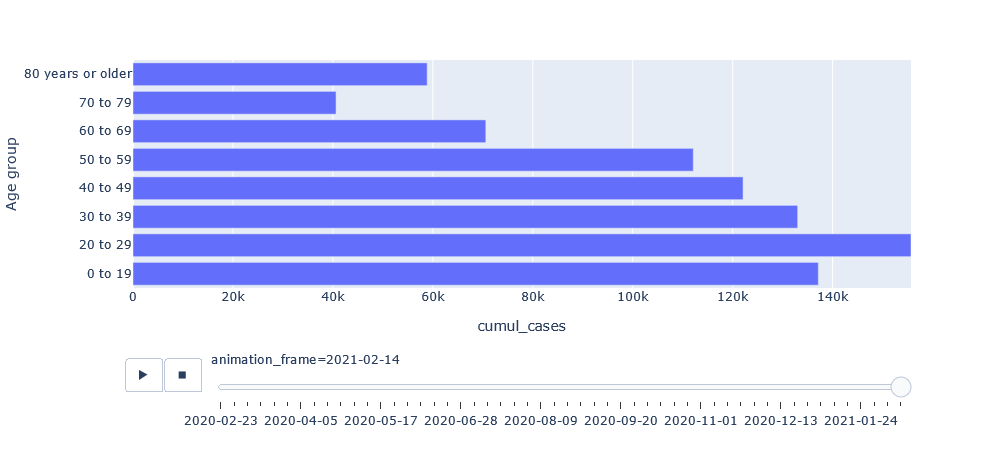

In [154]:
# This outputs an animated Plotly bar chart

ages_by_week = epi.groupby(['Week of', 'Age group']).size().reset_index(name = 'cases')
ages_by_week.sort_values(['Week of', 'Age group'], inplace = True)

# Calculate cumulative cases from the weekly case counts
ages_by_week['cumul_cases'] = ages_by_week.groupby('Age group').cases.cumsum()

px.bar(ages_by_week, x = 'cumul_cases', y = 'Age group', 
       animation_frame = ages_by_week['Week of'].astype(str), range_x = (0, ages_by_week.cumul_cases.max()))

Rate of increase by age group. Same data, but as a line chart.


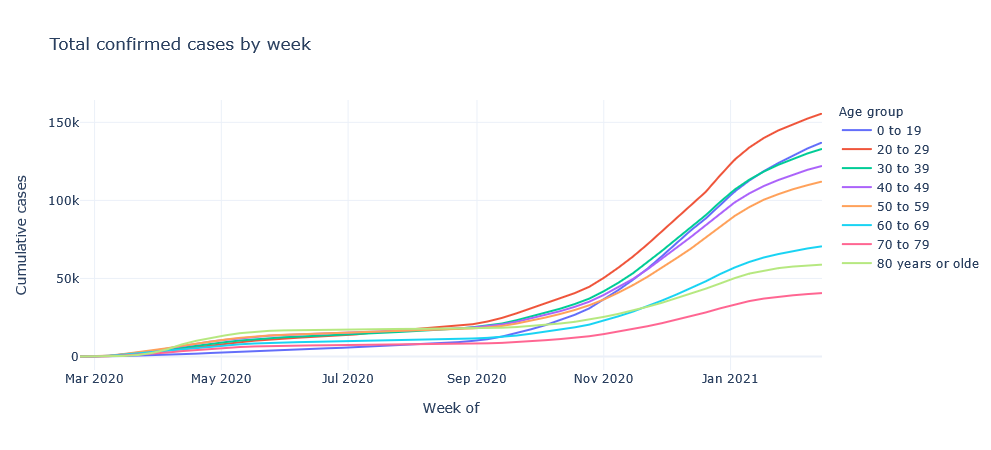

In [8]:
cases_by_age_weeks = epi.groupby(['Week of', 'Age group']).size().reset_index(name = 'New cases')
cases_by_age_weeks.sort_values('Week of', inplace = True)
cases_by_age_weeks['Cumulative cases'] = cases_by_age_weeks.groupby('Age group')['New cases'].cumsum()

# colors = dict(zip(cases_by_age_weeks['Age group'].unique(), ['red']*2 + ['grey']*6  ))

px.line(cases_by_age_weeks, x = 'Week of', y = 'Cumulative cases', 
        title = 'Total confirmed cases by week', template='plotly_white',
        color = 'Age group')

New weekly cases by age group

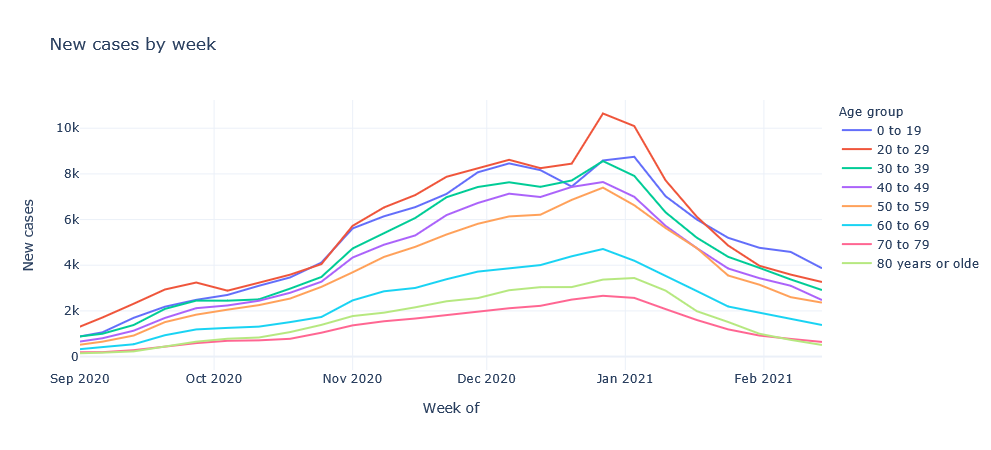

In [161]:
px.line(cases_by_age_weeks, x = 'Week of', y = 'New cases', 
        title = 'New cases by week', template='plotly_white',
        color = 'Age group', range_x = ['2020-09-01','2021-02-14'])

Let's see if there's a major change in cases between the oldest age group and the tounger ones. This may hint at a vaccine effect, like the [Financial Times](https://twitter.com/jburnmurdoch/status/1366445403772747787) has been doing.

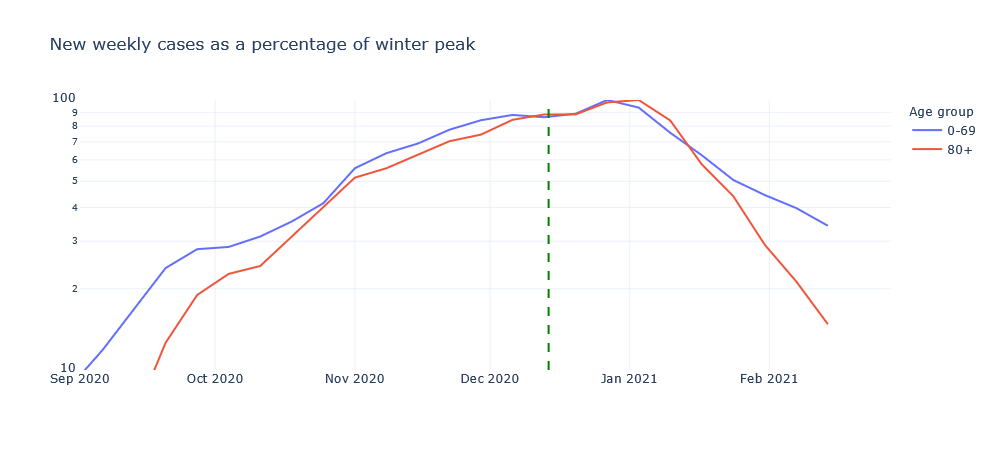

In [170]:
# Number of weekly cases by aggregated age groups
old_young_cases = epi.groupby(['Week of', 'Agg age group']).size().reset_index(name = 'New cases')

# Find the highest weekly case count for each group
case_peaks = old_young_cases.groupby('Agg age group')['New cases'].max()

# Calculate the percentage of these peaks for each group
old_young_cases['peak_pct'] = old_young_cases['New cases'] / old_young_cases['Agg age group'].map(case_peaks) * 100

px.line(old_young_cases.query('`Agg age group` != "70-79"'), x = 'Week of', y = 'peak_pct', 
        title = 'New weekly cases as a percentage of winter peak', template='plotly_white',
        color = 'Agg age group', range_x = ['2020-09-01', '2021-02-28'],
        range_y = (10, 100), log_y = True, labels={
                     "peak_pct": "",
                     "Week of": "",
                     "Agg age group": "Age group"
                 }
       ).add_vline(x = '2020-12-14', line_width=2, line_dash="dash", line_color="green")


### Hospitalizations

Cases by hospital status. This adds a row for total hospitalized.

In [9]:
hosp_status = epi.groupby('Hospital status').size().reset_index(name = 'count')
hosp_status = hosp_status.append({'Hospital status':'Total hospitalized', 
                    'count' : hosp_status.iloc[:2].sum()['count']},
                  ignore_index=True).set_index('Hospital status')
hosp_status

count
Hospital status                 
Hospitalized and in ICU     8253
Hospitalized, not in ICU   38681
Not Stated/Unknown        237528
Not hospitalized          555464
Total hospitalized         46934

Show it as a bar chart.

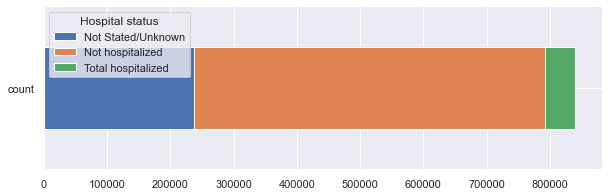

In [10]:
hosp_status.T.iloc[:, 2:].plot.barh(stacked = True, figsize = (10,3))

Hospitalization by age group

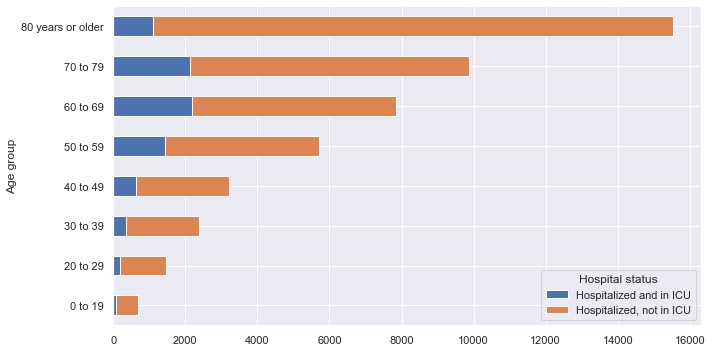

In [11]:
hosp_age = epi.groupby(['Age group', 'Hospital status']).size().unstack()
hosp_age[['Hospitalized and in ICU', 'Hospitalized, not in ICU']].plot.barh(stacked = True, figsize = (10,5))
plt.tight_layout()
plt.savefig('charts/hosp_age.png')

By age group over time

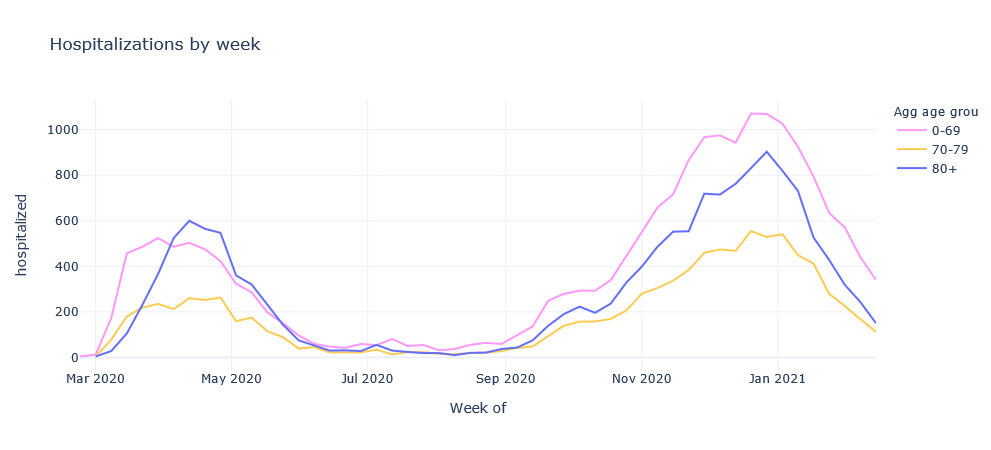

In [167]:
hosp_age_time = (epi[epi['Hospital status'].str.contains('Hospitalized')]
                 .groupby(['Agg age group', 'Week of'])
                 .size().reset_index(name = 'hospitalized'))
hosp_age_time.sort_values('Week of', inplace = True)

px.line(hosp_age_time, x = 'Week of', y = 'hospitalized', 
        title = 'Hospitalizations by week', template='plotly_white',
        color = 'Agg age group', color_discrete_map = colors)

As percentage of peak per age group, same as before

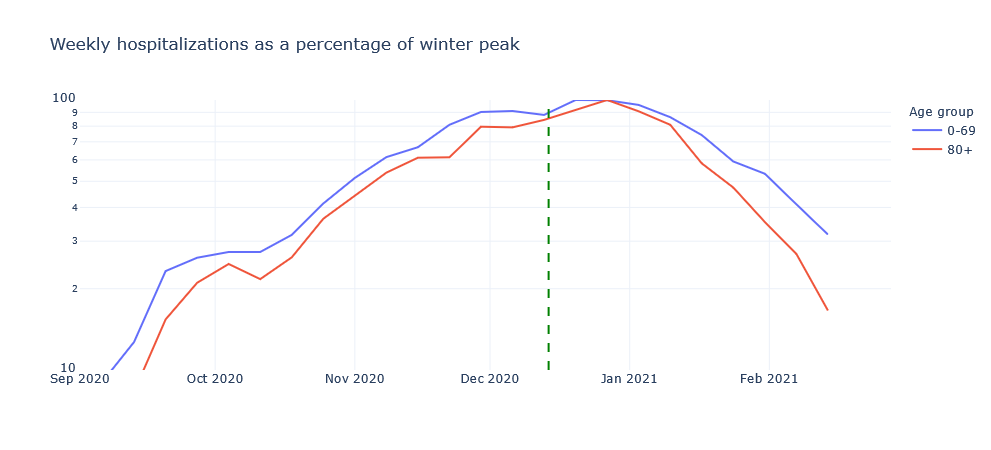

In [169]:
age_peaks = hosp_age_time.groupby('Agg age group').hospitalized.max()

hosp_age_time['peak_pct'] = hosp_age_time.hospitalized / hosp_age_time['Agg age group'].map(age_peaks) * 100

px.line(hosp_age_time.query('`Agg age group` != "70-79"'), x = 'Week of', y = 'peak_pct', 
        title = 'Weekly hospitalizations as a percentage of winter peak', template='plotly_white',
        color = 'Agg age group', range_x = ['2020-09-01', '2021-02-28'],
        range_y = (10, 100), log_y = True, labels={
                     "peak_pct": "",
                     "Week of": "",
                     "Agg age group": "Age group"
                 }
       ).add_vline(x = '2020-12-14', line_width=2, line_dash="dash", line_color="green")

Hospitalizations by gender

In [12]:
gender_hosp = epi.groupby(['Hospital status', 'Gender']).size().unstack(1)
gender_hosp.loc['Total hospitalized'] = gender_hosp.iloc[:2].sum()
gender_hosp

Gender                    Female    Male  Other/Not stated
Hospital status                                           
Hospitalized and in ICU     3011    5225                17
Hospitalized, not in ICU   19204   19429                48
Not Stated/Unknown        119022  117233              1273
Not hospitalized          289211  265856               397
Total hospitalized         22215   24654                65

Deaths vs. hospitalization


In [13]:
hospmort = epi.groupby(['Hospital status', 'Death']).size().unstack().iloc[:2, :]
hospmort

Death                        No  Not Stated   Yes
Hospital status                                  
Hospitalized and in ICU    5256         470  2527
Hospitalized, not in ICU  30021        1408  7252

### Deaths

Isolate deaths in the data

In [14]:
deaths = epi[epi.Death == 'Yes']
deaths.describe()

<ipython-input-14-7e2501ada7d1>:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



Case identifier number  Region Episode week Episode week group  \
count                   21420   21420        20097              21420   
unique                  21420       5           50                  1   
top                    528099  Quebec           15                  0   
freq                        1    9902         1445              21420   
first                     NaN     NaN          NaN                NaN   
last                      NaN     NaN          NaN                NaN   

       Episode year  Gender          Age group Occupation Asymptomatic  \
count         21138   21420              21072      21420        21420   
unique            2       3                  4          5            3   
top              20  Female  80 years or older      Other           No   
freq          17988   10930              14824      16117        16547   
first           NaN     NaN                NaN        NaN          NaN   
last            NaN     NaN                NaN        NaN          NaN   

       Onset week of symptoms Onset year of symptoms   Hospital status  \
count                   13089                  13089             21420   
unique                     50                      2                 4   
top                        15                     20  Not hospitalized   
freq                      809                  10976              9398   
first                     NaN                    NaN               NaN   
last                      NaN                    NaN               NaN   

       Recovered Recovery week Recovery year  Death          Transmission  \
count      21420             0             0  21420                 21420   
unique         1             0             0      1                     3   
top           No           NaN           NaN    Yes  Domestic acquisition   
freq       21420           NaN           NaN  21420                 19693   
first        NaN           NaN           NaN    NaN                   NaN   
last         NaN           NaN           NaN    NaN                   NaN   

                    Week of Agg age group  
count                 20097         21420  
unique                   50             3  
top     2020-04-12 00:00:00           80+  
freq                   1445         14824  
first   2020-03-01 00:00:00           NaN  
last    2021-02-14 00:00:00           NaN

Deaths by gender

In [127]:
deaths.Gender.value_counts()

Female              10930
Male                10439
Other/Not stated       51
Name: Gender, dtype: int64

Cumulative deaths by gender over time

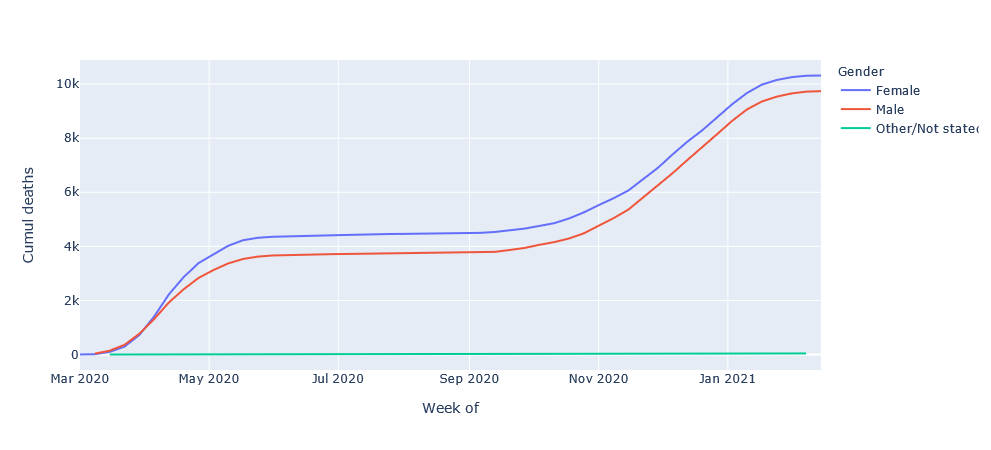

In [15]:
# This outputs an interactive Plotly line chart

deaths_week = deaths.groupby(['Week of', 'Gender']).size().reset_index(name = 'deaths')
deaths_week.sort_values('Week of', inplace = True)
deaths_week['Cumul deaths'] = deaths_week.groupby('Gender').deaths.cumsum()

px.line(deaths_week, x = 'Week of', y = 'Cumul deaths', color = 'Gender')

Deaths by age and gender. This data doesn't conlude deaths under 50. For this, it's better to use the aggregate [PHAC epidemiological summary](https://health-infobase.canada.ca/covid-19/epidemiological-summary-covid-19-cases.html).

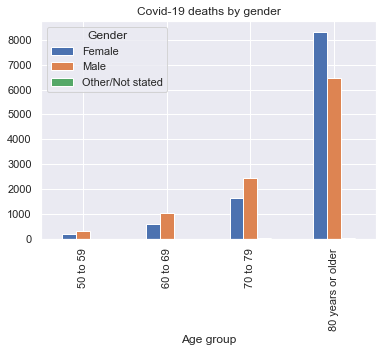

In [16]:
deaths_age = deaths.groupby(['Age group', 'Gender']).size().unstack()

deaths_age.plot.bar(title = "Covid-19 deaths by gender")

Death rate over time. This is the number of deaths divided by total cases by week.

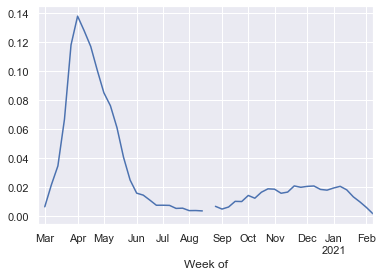

In [131]:
epi.groupby(['Week of', 'Death']).size().unstack().apply(lambda x: x/ x.sum(), axis = 1).Yes.plot()

### Symptoms

**Note: symptom data has been removed from the dataset. This is for historical record only.**

Symptoms are noted in individulas columns for each, as `Yes`, `No`, or `Not reported`. To get an idea of symptoms frequency, you need to sum the `Yes` and `No` values and calculate how many are `Yes`.

In [8]:
# Isolate symptom columns
sympt = [c for c in epi.columns if 'Symptom' in c]

# Create a dataframe of symptom counts
sympdf = epi[sympt].apply(pd.Series.value_counts).T
sympdf

Not Stated     Yes     No
Symptom, cough                    575521   84800   5916
Symptom, fever                    589836   67689   8712
Symptom, chills                   632405   30624   3208
Symptom, sore throat              606928   50580   8729
Symptom, runny nose               620603   42097   3537
Symptom, shortness of breath      626355   28840  11042
Symptom, nausea                   643026   17930   5281
Symptom, headache                 586771   72259   7207
Symptom, weakness                 625740   37890   2607
Symptom, pain                     616505   46082   3650
Symptom, irritability             653647    7465   5125
Symptom, diarrhea                 638629   22331   5277
Symptom, other                    515066  127046  24125

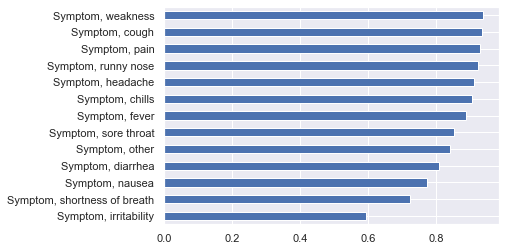

In [68]:
# Most common symptoms overall

sympdf[['Yes', 'No']].div(sympdf.Yes + sympdf.No, axis = 0).sort_values('Yes').Yes.plot.barh()

Rough idea of how many cases have symptom information

In [69]:
(sympdf.No + sympdf.Yes).median()

45634.0

Calculate frequency of symptoms by age. The table below shows the percentage of cases by age of where a symptom is `Yes`.

In [70]:
symptoms_age = (epi.melt(id_vars = 'Age group', value_vars=sympt, var_name='Symptom')
 .groupby(['Age group', 'Symptom', 'value']).size()
 .unstack()
 .reset_index()
 .assign(prop = lambda x: x.Yes / (x.No + x.Yes) * 100)
 .pivot(index = 'Symptom', columns = 'Age group', values = 'prop')
 )

symptoms_age

Age group                       0 to 19   20 to 29   30 to 39   40 to 49  \
Symptom                                                                    
Symptom, chills               85.662100  92.438472  92.626800  93.290507   
Symptom, cough                89.814066  92.373640  93.411181  95.153709   
Symptom, diarrhea             71.842561  82.030548  81.254026  84.382470   
Symptom, fever                87.887453  86.193019  88.498129  90.514331   
Symptom, headache             89.810076  92.779564  92.626544  93.527884   
Symptom, irritability         49.459877  60.441767  59.637077  64.366128   
Symptom, nausea               71.160714  80.179257  78.241206  80.801172   
Symptom, other                79.960864  83.671957  84.448366  85.614549   
Symptom, pain                 83.937008  93.619176  94.451307  95.857872   
Symptom, runny nose           92.583309  94.935079  93.634085  93.633399   
Symptom, shortness of breath  58.287596  68.926468  71.451756  75.624549   
Symptom, sore throat          86.803154  88.319639  86.812779  88.157895   
Symptom, weakness             90.198511  94.407346  94.280336  95.440567   

Age group                      50 to 59   60 to 69   70 to 79  \
Symptom                                                         
Symptom, chills               92.088460  88.651415  79.756469   
Symptom, cough                94.834249  94.267013  93.342863   
Symptom, diarrhea             83.012366  79.141960  77.357320   
Symptom, fever                89.416645  88.044249  87.956469   
Symptom, headache             91.882706  88.018504  79.241071   
Symptom, irritability         57.432432  51.062092  57.638889   
Symptom, nausea               79.191176  73.758562  69.679540   
Symptom, other                85.809821  84.887711  83.535393   
Symptom, pain                 94.542958  91.191710  85.145482   
Symptom, runny nose           91.515994  88.169257  83.845724   
Symptom, shortness of breath  74.117473  72.301236  76.928983   
Symptom, sore throat          84.244373  80.077885  73.426890   
Symptom, weakness             94.332042  92.263610  90.636882   

Age group                     80 years or older  
Symptom                                          
Symptom, chills                       67.405063  
Symptom, cough                        93.280573  
Symptom, diarrhea                     80.082742  
Symptom, fever                        90.850537  
Symptom, headache                     73.871092  
Symptom, irritability                 73.483536  
Symptom, nausea                       73.833206  
Symptom, other                        86.126034  
Symptom, pain                         83.646813  
Symptom, runny nose                   85.891918  
Symptom, shortness of breath          78.641092  
Symptom, sore throat                  71.683341  
Symptom, weakness                     91.331612

Visualize that as a Seaborn heatmap.

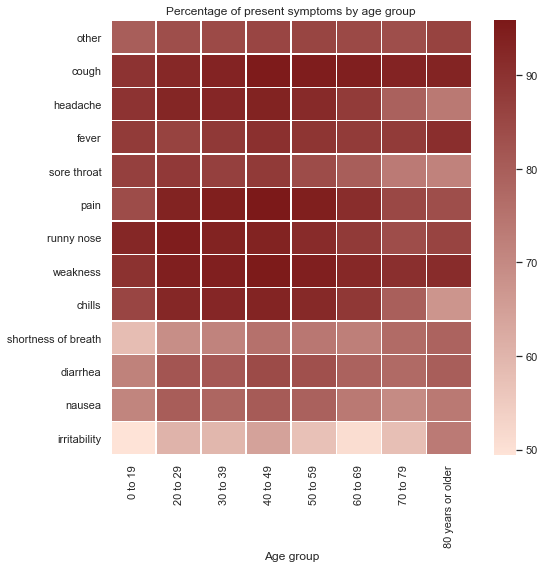

In [71]:
# Create a custom colour gradient using CBC reds.
from matplotlib.colors import LinearSegmentedColormap 
    
cmap = LinearSegmentedColormap.from_list(name='CBC red', 
                                         colors =['#fee3d7', '#7c1919'])

# Order index by most common symptom overall
sym_order = sympdf.sort_values('Yes', ascending = False).index
symptoms_age = symptoms_age.reindex(sym_order)

# REmvoer the word "Symptom" from the index
symptoms_age.index = symptoms_age.index.str.replace('Symptom, ', '')

# Plot it
plt.figure(figsize=(8,8))
sns.heatmap(symptoms_age, linewidths=.5, cmap=cmap)
plt.title('Percentage of present symptoms by age group')
plt.tight_layout()

Do the same with hospitalization status, sorting by most common symptom in hospitalized cases.

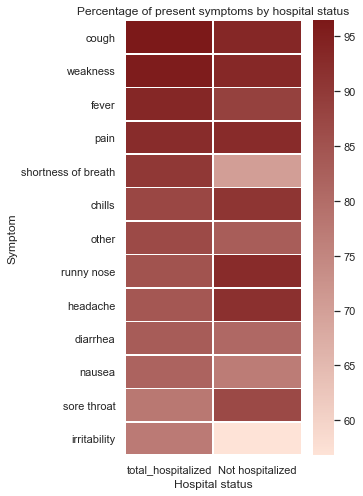

In [72]:
symptoms_hosp =  (epi.melt(id_vars = 'Hospital status', value_vars=sympt, var_name='Symptom')
  .groupby(['Hospital status', 'Symptom', 'value']).size()
  .unstack(0)
  .assign(total_hospitalized = lambda x: x['Hospitalized and in ICU'] + x['Hospitalized, not in ICU'])
  .stack().unstack(1)
  .reset_index()
  .assign(prop = lambda x: x.Yes / (x.No + x.Yes) * 100)
  .pivot(index = 'Symptom', columns = 'Hospital status', values = 'prop')
  .sort_values('total_hospitalized', ascending = False)
 )
symptoms_hosp.index = symptoms_hosp.index.str.replace('Symptom, ', '')


plt.figure(figsize=(5,7))
sns.heatmap(symptoms_hosp[['total_hospitalized', 'Not hospitalized']] , linewidths=.5, cmap = cmap)
plt.title('Percentage of present symptoms by hospital status')
plt.tight_layout()

And with fatal vs. non-fatal cases.

In [73]:
symptoms_death =  (epi.melt(id_vars = 'Death', value_vars=sympt, var_name='Symptom')
 .groupby(['Death', 'Symptom', 'value']).size()
 .unstack()
 .reset_index()
 .assign(prop = lambda x: x.Yes / (x.No + x.Yes) * 100)
 .pivot(index = 'Symptom', columns = 'Death', values = 'prop')
 .sort_values('Yes', ascending = False)
 )
symptoms_death.index = symptoms_death.index.str.replace('Symptom, ', '')

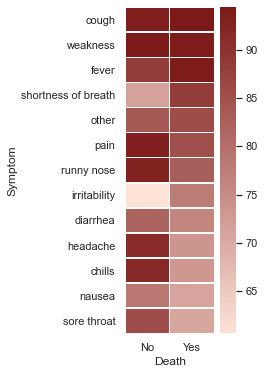

In [74]:
plt.figure(figsize=(2,6))
sns.heatmap(symptoms_death[['No', 'Yes']], linewidths=.5, cmap=cmap) 

### Recovery

Breakdown of recovered cases

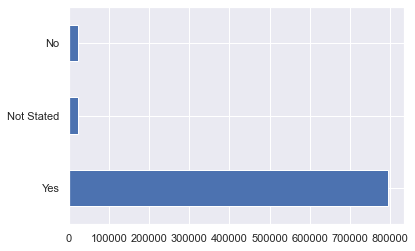

In [175]:
epi.Recovered.value_counts().plot.barh()

Number of recovered cases by age

In [17]:
epi.groupby(['Age group', 'Recovered']).size().unstack(0).fillna(0).reindex(['Yes', 'No', 'Not Stated'])

Age group    0 to 19  20 to 29  30 to 39  40 to 49  50 to 59  60 to 69  \
Recovered                                                                
Yes         133557.0  153111.0  130490.0  119832.0  109570.0   67912.0   
No               0.0       0.0       0.0       0.0     522.0    1629.0   
Not Stated    4914.0    3929.0    3635.0    3305.0    3123.0    2063.0   

Age group   70 to 79  80 years or older  
Recovered                                
Yes          36366.0            43817.0  
No            4097.0            14824.0  
Not Stated    1120.0             1495.0

Average time to recovery by age group. Episode week used as start of disesase, since Episode onset column is unreliable.


In [179]:
# Isolate recovered cases
recov = epi[epi['Onset week of symptoms'].notna()]
recov[['Onset week of symptoms', 'Recovery week']] = recov[['Onset week of symptoms', 'Recovery week']].astype(float)

# Calculate the lag between onset and recovery
recov['week_lag'] = recov['Recovery week'] - recov['Onset week of symptoms']

recov_lags = recov.groupby('Age group').week_lag.describe()
recov_lags

C:\Users\Beto\miniconda3\envs\data\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-179-aedf21d7de3a>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



count      mean       std  min  25%  50%  75%   max
Age group                                                               
0 to 19            53912.0  1.860662  0.914084  0.0  1.0  2.0  2.0  41.0
20 to 29           56169.0  1.892895  1.012858  0.0  1.0  2.0  2.0  16.0
30 to 39           52150.0  1.926942  0.992635  0.0  1.0  2.0  2.0  17.0
40 to 49           49975.0  1.957039  1.015535  0.0  1.0  2.0  2.0  14.0
50 to 59           41951.0  2.006937  1.083905  0.0  1.0  2.0  2.0  14.0
60 to 69           24063.0  2.081453  1.124905  0.0  1.0  2.0  2.0  15.0
70 to 79           11654.0  2.247640  1.268925  0.0  2.0  2.0  3.0  14.0
80 years or older  11631.0  2.982719  1.651481  0.0  2.0  3.0  4.0  13.0

Plot average recovery time and the max for each age group.

Text(0.5, 1.0, 'Average and max recovery time (weeks) by age group')

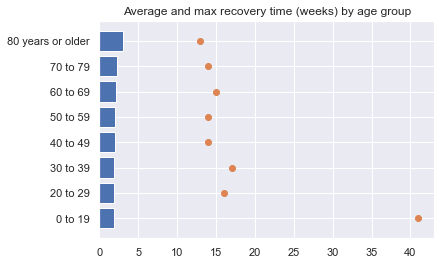

In [180]:
fig, ax = plt.subplots()
ax.barh(recov_lags.index, recov_lags['mean'])
ax.scatter(recov_lags['max'], recov_lags.index)
plt.title('Average and max recovery time (weeks) by age group')

Average recovery time by hospital status

In [183]:
recov.groupby('Hospital status').week_lag.mean()

Hospital status
Hospitalized and in ICU     3.291966
Hospitalized, not in ICU    2.746223
Not Stated/Unknown          2.744186
Not hospitalized            1.956074
Name: week_lag, dtype: float64

### Other variables

These are other columns in the data that didn't make it into the story. I leave them here for interest.

Transmission type over time. Note how infections from international travel pick up around week 26.

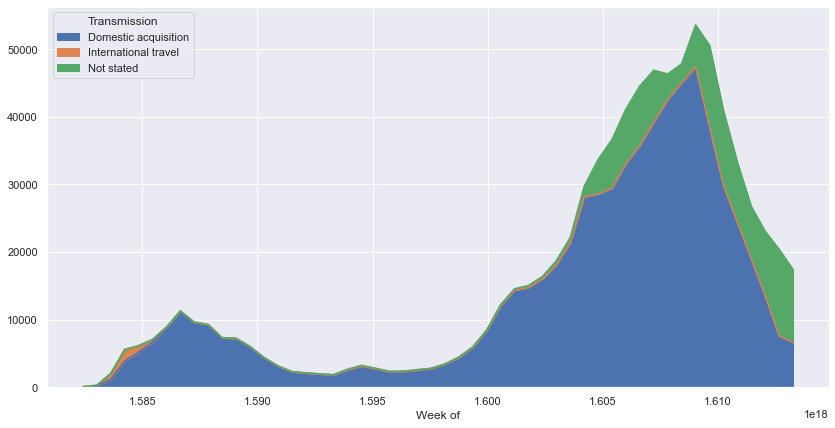

In [191]:
transmision_time = epi.groupby(['Week of', 'Transmission']).size().unstack()
transmision_time.index = transmision_time.index.astype(int)
transmision_time.sort_index().plot.area(figsize = (14,7))

Cases by region. StatCan lumps provinces together for privacy reasons, making this pretty useless.

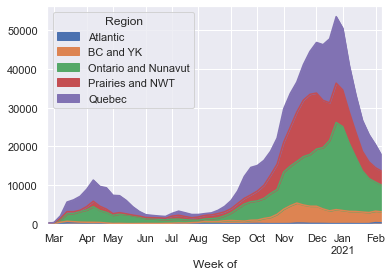

In [196]:
epi.groupby(['Week of','Region']).size().unstack().plot.area()

Number of asymptomatic cases. Numbers too small to be useful.

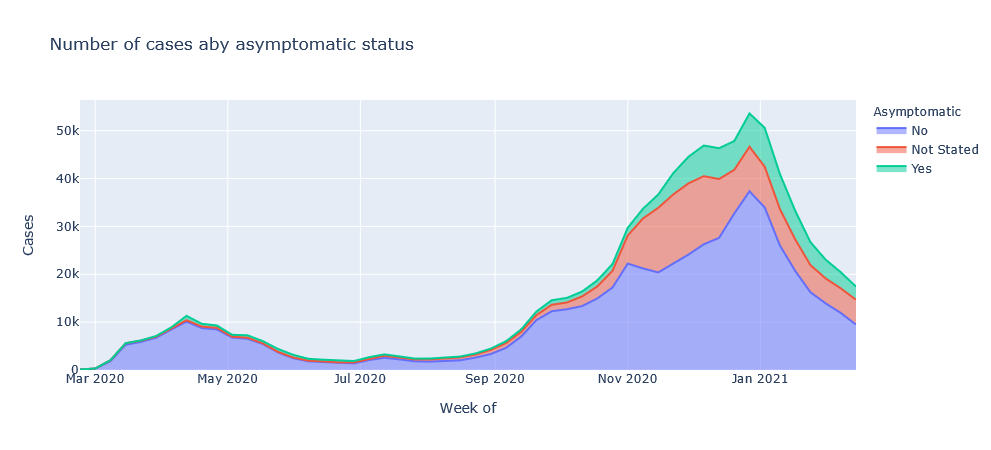

In [204]:
asymp = epi.groupby(['Week of','Asymptomatic']).size().reset_index(name = 'Cases')
px.area(asymp, x = 'Week of', y = 'Cases', color = 'Asymptomatic',  title = 'Number of cases aby asymptomatic status')

Number of cases by occupation. Only 3 occupations are recorded, and it's a small sample of the total data.

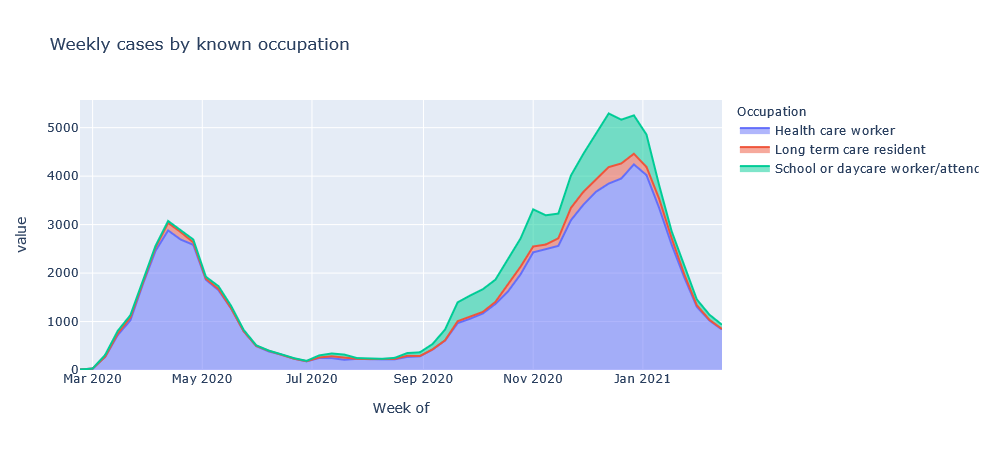

In [216]:
occup = epi.groupby(['Week of', 'Occupation']).size().unstack().iloc[:, [0,1,4]]
px.area(occup, x = occup.index, y = occup.columns, title = 'Weekly cases by known occupation')

Number of deaths by occupation. Even less useful.

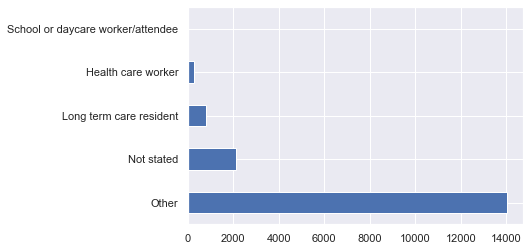

In [85]:
deaths_occupations = epi.query('Death == "Yes"').Occupation.value_counts()

deaths_occupations.plot.barh(stacked=True)